<a href="https://colab.research.google.com/github/choibumku00/Hands-on-GNN/blob/main/code/chapter14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explaining Graph Neural Networks

In [ ]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric~=2.0.4 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q captum==0.6.0

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric~=2.0.4 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q captum==0.6.0

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.5/407.5 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.0 MB/s eta 0:00:00


## GNNExplainer

In [ ]:
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool, GNNExplainer

dataset = TUDataset(root='data/TUDataset', name='MUTAG').shuffle()

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        h = torch.cat((h1, h2, h3), dim=1)

        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return F.log_softmax(h, dim=1)

model = GIN(dim_h=32)

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 200

model.train()
for epoch in range(epochs+1):
    total_loss = 0
    acc = 0
    val_loss = 0
    val_acc = 0

    # Train on batches
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        total_loss += loss / len(train_loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(train_loader)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss, val_acc = test(model, val_loader)

    # Print metrics every 20 epochs
    if(epoch % 20 == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

test_loss, test_acc = test(model, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

Epoch   0 | Train Loss: 1.42 | Train Acc: 60.98% | Val Loss: 0.81 | Val Acc: 47.37%
Epoch  20 | Train Loss: 0.42 | Train Acc: 78.93% | Val Loss: 0.66 | Val Acc: 57.89%
Epoch  40 | Train Loss: 0.41 | Train Acc: 81.44% | Val Loss: 0.45 | Val Acc: 73.68%
Epoch  60 | Train Loss: 0.33 | Train Acc: 81.96% | Val Loss: 0.62 | Val Acc: 68.42%
Epoch  80 | Train Loss: 0.26 | Train Acc: 89.68% | Val Loss: 0.58 | Val Acc: 73.68%
Epoch 100 | Train Loss: 0.24 | Train Acc: 86.65% | Val Loss: 0.60 | Val Acc: 63.16%
Epoch 120 | Train Loss: 0.23 | Train Acc: 92.23% | Val Loss: 0.54 | Val Acc: 68.42%
Epoch 140 | Train Loss: 0.21 | Train Acc: 91.76% | Val Loss: 0.46 | Val Acc: 78.95%
Epoch 160 | Train Loss: 0.19 | Train Acc: 92.23% | Val Loss: 0.69 | Val Acc: 73.68%
Epoch 180 | Train Loss: 0.17 | Train Acc: 93.80% | Val Loss: 0.59 | Val Acc: 73.68%
Epoch 200 | Train Loss: 0.18 | Train Acc: 90.25% | Val Loss: 0.57 | Val Acc: 73.68%
Test Loss: 0.41 | Test Acc: 73.68%


In [ ]:
# GNNExplainer의 마스킹 기법을 통해 노드 특성의 중요도 파악
explainer = GNNExplainer(model, epochs=100, num_hops=1)
data = dataset[-2]
feature_mask, edge_mask = explainer.explain_graph(data.x, data.edge_index)
feature_mask

Explain graph: 100%|██████████| 100/100 [00:00<00:00, 187.77it/s]


tensor([0.7888, 0.6873, 0.7225, 0.6795, 0.2795, 0.2587, 0.3060])

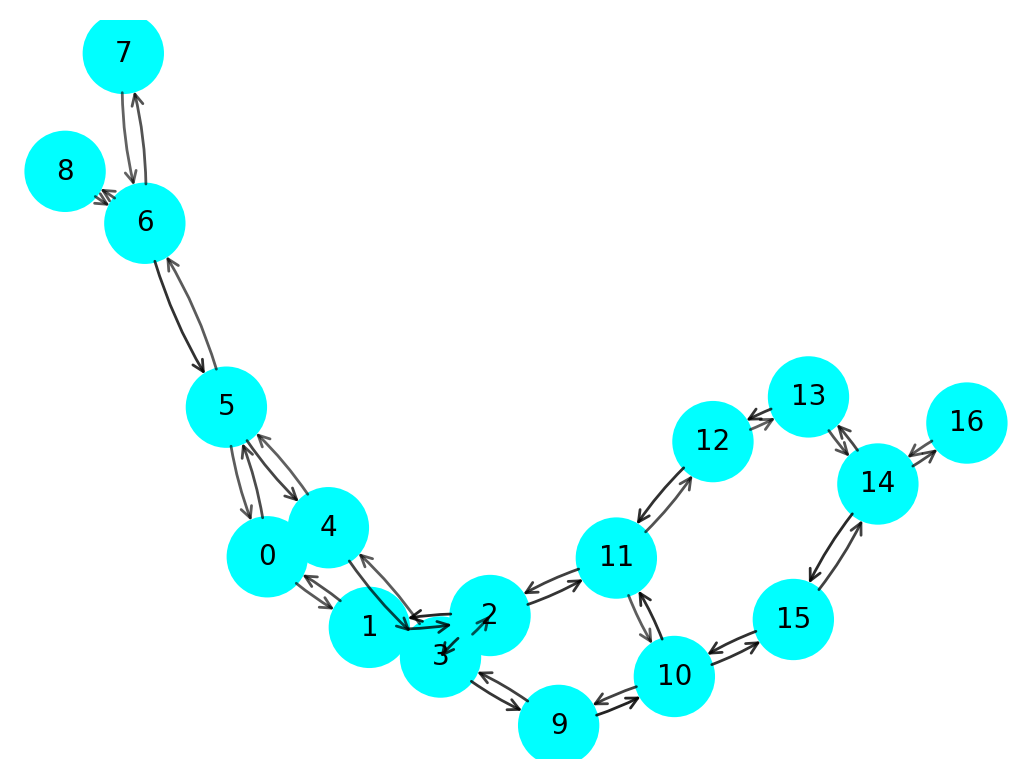

In [ ]:
# 원자마다 결합의 중요도 출력 (투명도)
fig = plt.figure(dpi=200)
ax, G = explainer.visualize_subgraph(-1, data.edge_index, edge_mask, y=data.y)
ax.axis('off')
plt.show()
# test 셋이 사람마다 달라 다르게 보일 수 있음 or Dropout의 영향으로 다르게 보임

## Explaining GNNs with Captum

In [ ]:
import numpy as np
np.random.seed(0)
import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from captum.attr import IntegratedGradients

import torch_geometric.transforms as T
from torch_geometric.datasets import Twitch
from torch_geometric.nn import Explainer, GCNConv, to_captum


dataset = Twitch('.', name="EN")
data = dataset[0]

class GCN(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv2(h, edge_index)
        return F.log_softmax(h, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    log_logits = model(data.x, data.edge_index)
    loss = F.nll_loss(log_logits, data.y)
    loss.backward()
    optimizer.step()

def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1), data.y)
    return acc

acc = test(model, data)
print(f'Accuracy: {acc*100:.2f}%')

Processing...
Done!


Accuracy: 69.00%


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


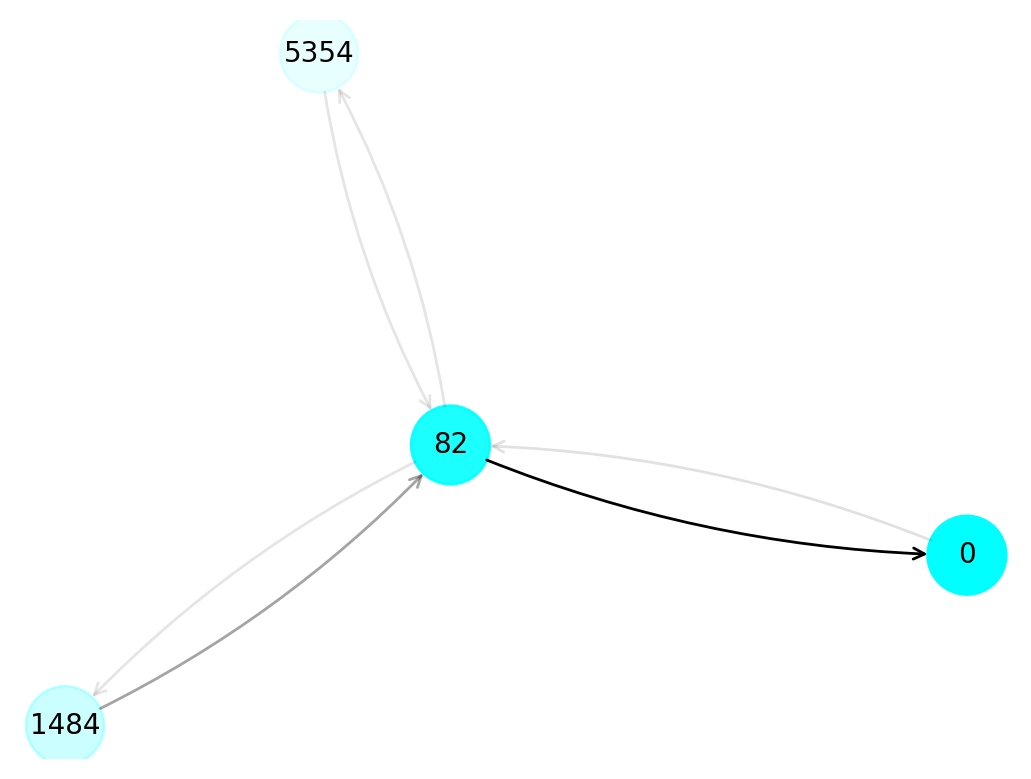

In [ ]:
# captum의 통합 그레디언트 기법을 통해 중요도 판단
node_idx = 0
captum_model = to_captum(model, mask_type='node_and_edge', output_idx=node_idx) #노드 및 특성 마스크를 사용하고 싶다면(mask_type=node_and_feature)
# 통합 그레디언트 기법을 사용하기 위한 IntegratedGradients 객체를 생성
ig = IntegratedGradients(captum_model)
edge_mask = torch.ones(data.num_edges, requires_grad=True, device=device)

# 노드 및 엣지의 중요도를 계산
# 그래프의 노드 및 엣지 특성을 입력으로, 추가적인 전달 인수(엣지 인덱스)를 제공
attr_node, attr_edge = ig.attribute(
    (data.x.unsqueeze(0), edge_mask.unsqueeze(0)),
    target=int(data.y[node_idx]),
    additional_forward_args=(data.edge_index),
    internal_batch_size=1)

attr_node = attr_node.squeeze(0).abs().sum(dim=1)
attr_node /= attr_node.max()
attr_edge = attr_edge.squeeze(0).abs()
attr_edge /= attr_edge.max()

# 엣지에 투명도를 통하여 중요도 파악
fig = plt.figure(dpi=200)
explainer = Explainer(model)
ax, G = explainer.visualize_subgraph(node_idx, data.edge_index, attr_edge, node_alpha=attr_node, y=data.y)
ax.axis('off')
plt.show()

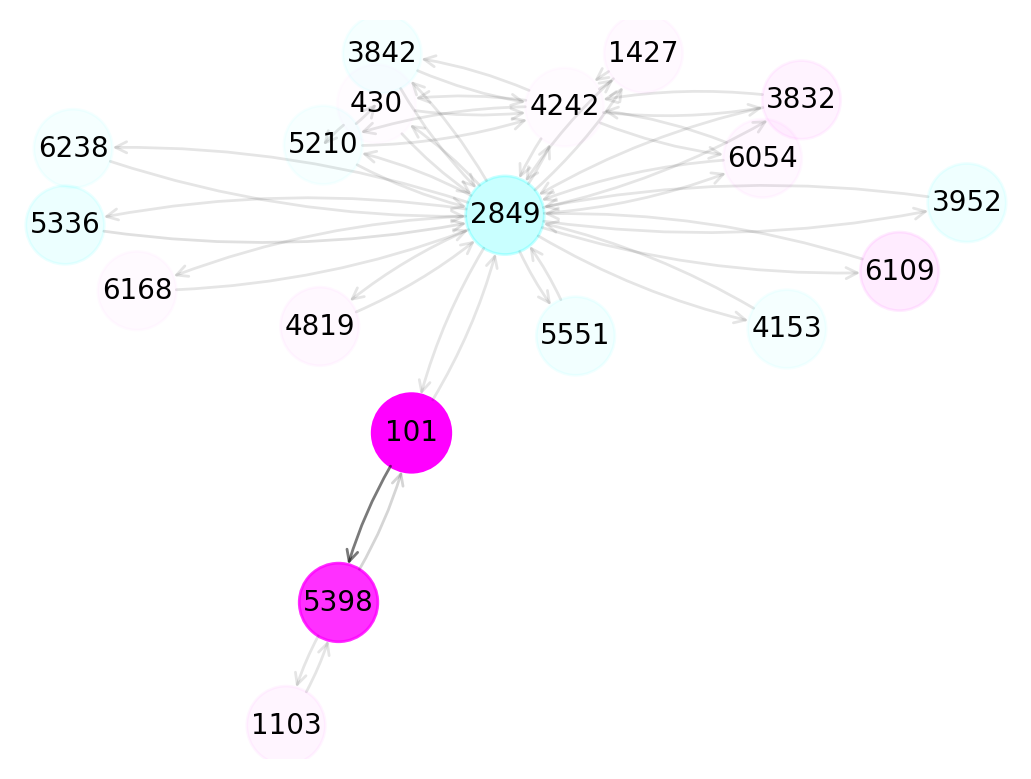

In [ ]:
node_idx = 101 # node id(사용자) 101
captum_model = to_captum(model, mask_type='node_and_edge', output_idx=node_idx)
ig = IntegratedGradients(captum_model)
edge_mask = torch.ones(data.num_edges, requires_grad=True, device=device)

attr_node, attr_edge = ig.attribute(
    (data.x.unsqueeze(0), edge_mask.unsqueeze(0)),
    target=int(data.y[node_idx]),
    additional_forward_args=(data.edge_index),
    internal_batch_size=1)

attr_node = attr_node.squeeze(0).abs().sum(dim=1)
attr_node /= attr_node.max()
attr_edge = attr_edge.squeeze(0).abs()
attr_edge /= attr_edge.max()

fig = plt.figure(dpi=200)
explainer = Explainer(model)
ax, G = explainer.visualize_subgraph(node_idx, data.edge_index, attr_edge, node_alpha=attr_node, y=data.y)
ax.axis('off')
plt.show()